In [24]:
%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# VIEWING OPTIONS IN THE NOTEBOOK
from sklearn import set_config
set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('data_for_model_2.csv')
#data = pd.read_csv('../data/data_for_model_2.csv')
data['snow'] = data['snow'].replace(np.nan, 0)

data.head()
X = data[['city','temp', 'prcp', 'wspd', 'wpgt', 'snow', 'coco', 'weekday', 'month', 'time_of_day']]
#y = data['target_numeric']
y = data['target'] # for classification

y[y == 'on time'] = 0 # can use binary for logistic regression
y[y == 'small delay'] = 0
y[y == 'medium delay'] = 1
y[y == 'large delay/cancelled'] = 1
y=y.astype('int') # important as otherwise it gets attributed "object" type, which is bad for models
#y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: Se

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

def create_preproc_ordinal():
    feat_ordinal_dict = {
        # considers "missing" as the worse category
        "coco": ['good', 'medium', 'bad', 'extreme']
    }

    feat_ordinal = sorted(feat_ordinal_dict.keys())
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        handle_unknown="use_encoded_value",
        unknown_value=-1  # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

    return preproc_ordinal, feat_ordinal


def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

In [57]:
def create_preproc(X, percentile = 75):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for the Houses Kaggle Competition

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """
    preproc_ordinal, feat_ordinal = create_preproc_ordinal()
    
    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)
    
    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(
        list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))
    
    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("ordinal_encoder", preproc_ordinal, feat_ordinal),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    feature_selector = SelectPercentile(
        mutual_info_regression,
        percentile=percentile,  # keep the xx% most important features
    )

    preproc = make_pipeline(
        feature_transformer
        #feature_selector
    )
    return preproc

In [58]:
preproc = create_preproc(X_train)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['good',
                                                                                               'medium',
                                                                                               'bad',
                                                                                               'extreme']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'month',
                                                   'time_of_day',
                                                   'weekday'])]))])

In [59]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['good',
                                                                                               'medium',
                                                                                               'bad',
                                                                                               'extreme']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'month',
                                                   'time_of_day',
                                                   'weekday'])]))])

In [60]:
# Create the preprocessed versions of X_train and X_val
X_train_preproc = preproc.transform(X_train)
X_val_preproc = preproc.transform(X_val)

# Let's also already create the preprocessed version of X_test for our future predictions
X_test_preproc = preproc.transform(X_test)

In [61]:
# Shapes before preprocessing
X_train.shape, X_val.shape #X_test.shape

((30059, 10), (6012, 10))

In [62]:
# Shapes after preprocessing
X_train_preproc.shape, X_val_preproc.shape #,X_test_preproc.shape

((30059, 31), (6012, 31))

# Logistic regression

In [63]:
pd.DataFrame(y_test)#.dtypes


,target
5140,0
4957,0
36795,1
27910,0
10334,1
...,...
20706,0
39074,0
12856,1
22272,1


In [64]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

log_reg = LogisticRegression(max_iter=10000) 

cv_results = cross_validate(log_reg, X_train_preproc, y_train, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )

log_reg.fit(X_test_preproc,y_test)
cv_results = pd.DataFrame(cv_results)
r2 = cv_results['test_r2'].mean()
max_error = cv_results['test_max_error'].max()

In [84]:
r2

-0.5406702234981353

# KNN Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


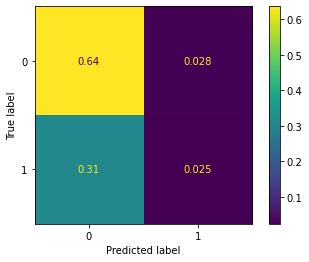

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train_preproc,y_train)
#y_pred = cross_val_predict(model,X_val_preproc,y_val,cv=5,method='predict').T
y_pred = neigh.predict(X_test_preproc)

plot_confusion_matrix(neigh,X_test_preproc,y_test,normalize='all') 
plt.show()


In [78]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_true = y_test
accuracy = round(accuracy_score(y_true, y_pred), 2)
precision = round(precision_score(y_true, y_pred), 2)
recall = round(recall_score(y_true, y_pred), 2)
f1_score = round(f1_score(y_true, y_pred), 2)

print(accuracy)
print(precision)
print(recall)
print(f1_score)

0.66
0.47
0.07
0.13


# CNN Classifier

In [85]:
from tensorflow.keras import Sequential, layers

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################
    
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(50, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='softmax')) 
    
    # Compiler   
   
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])  
    
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)

es = EarlyStopping(patience=3, restore_best_weights=True)

# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train_preproc)
model.summary()

# 2. Training the model
epochs = 50
batch_size = 16

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,        
                    batch_size = batch_size, 
                    callbacks=[es],
                    verbose = 1)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                1600      
                                                                 
 dense_11 (Dense)            (None, 15)                765       
                                                                 
 dense_12 (Dense)            (None, 15)                240       
                                                                 
 dense_13 (Dense)            (None, 20)                320       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,946
Trainable params: 2,946
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1879/1879 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3490

In [ ]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

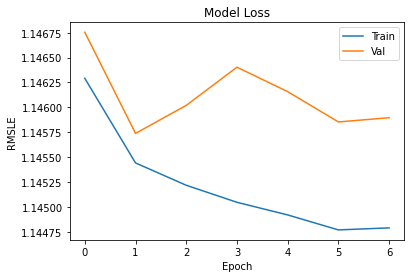

In [ ]:
plot_history(history)

# PREDICTION

In [ ]:
X_test_preproc = preproc.transform(X_test)
predictions = model.predict(X_test_preproc)

<AxesSubplot:xlabel='target_numeric', ylabel='Count'>

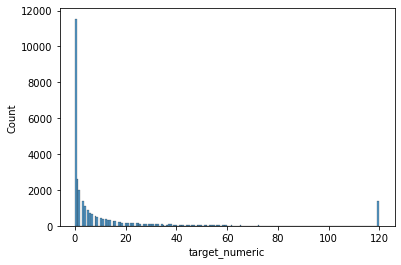

In [ ]:
sns.histplot(y_train)

<AxesSubplot:ylabel='Count'>

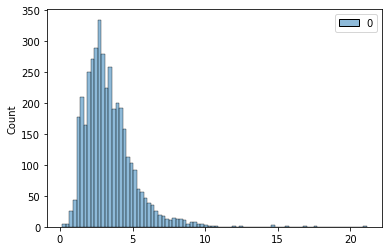

In [ ]:
sns.histplot(predictions)

In [ ]:
#calculate error of test (unfinished)
pd.DataFrame(predictions, np.array(y_test)).reset_index()

,index,0
0,0,3.751115
1,9,2.680005
2,5,2.469314
3,0,4.324683
4,2,2.083466
...,...,...
4003,1,1.619326
4004,9,2.520641
4005,0,2.439794
4006,1,3.190709
